In [85]:
from scipy.optimize import minimize
import numpy as np
from scipy.linalg import block_diag
import time

# give the 1,2 norm of a vector in 2d
def norm12(x):
    norm = 0
    for i in range(int(len(x)/2)):
        norm = norm + np.sqrt(x[2*i]**2 + x[2*i+1]**2)
    return norm


#make sure n and d are even
n = 10000
d = 50

def gen_train_data(n, d):
    A = np.zeros((n,d),dtype=np.complex_)
    x = np.zeros((d,1),dtype=np.complex_)
    y = np.zeros((n,1),dtype=np.complex_)
    for i in range(n):
        for j in range(d):
            a = np.random.rand()*10
            b = np.random.rand()*10
            A[i,j]=complex(a,b)

    for i in range(d):
        a = np.random.rand()
        b = np.random.rand()
        x[i] = complex(a,b)

    exact_res = 0
    for i in range(n):
        a = np.random.laplace()*0.01
        b = np.random.laplace()*0.01
        exact_res = exact_res + np.sqrt(a**2+b**2)
        y[i] = np.vdot(A[i,:], x) + complex(a,b)
    return (A, x, y, exact_res)

    
def gen_test(n, d, A, x):  
    noise = 0
    for i in range(n):
        a = np.random.laplace()*0.01
        b = np.random.laplace()*0.01
        noise = noise + np.sqrt(a**2+b**2)
        y[i] = np.vdot(A[i,:], x) + complex(a,b)
    return (y, noise)

def gen_rand_test(n, d, x):  
    noise = 0
    A = np.zeros((n,d),dtype=np.complex_)

    for i in range(n):
        for j in range(d):
            a = np.random.rand()*10
            b = np.random.rand()*10
            A[i,j]=complex(a,b)
    for i in range(n):
        a = np.random.laplace()*0.01
        b = np.random.laplace()*0.01
        noise = noise + np.sqrt(a**2+b**2)
        y[i] = np.vdot(A[i,:], x) + complex(a,b)
    return (A, y, noise)

def unfold_mat(A):
    n = A.shape[0]*2
    d = A.shape[1]*2
    B = np.zeros((n, d))
    for i in range(int(n/2)):
        for j in range(int(d/2)):
            curr = A[i, j]
            a = curr.real
            b = curr.imag
            B[2*i, 2*j] = a
            B[2*i, 2*j+1] = b
            B[2*i+1, 2*j] = -b
            B[2*i+1, 2*j+1] = a
    return B

def unfold_vec(x):
    d = x.shape[0]*2
    y = np.zeros((d, 1))
    for i in range(int(d/2)):
        curr = x[i]
        a = curr.real
        b = curr.imag
        y[2*i]= a
        y[2*i+1] = b
    return y

def gen_gaussian(k, t, n):
    block_list = []
    G = np.random.randn(k, t) / k*np.sqrt(np.pi/2)
    for i in range(n):
        
        block_list.append(G)
    return block_diag(*block_list)


In [102]:
from l1 import l1
import cvxopt
from cvxopt import normal

(A, x, y, train_noise)=gen_train_data(n,d)

AA = unfold_mat(A)
yy = unfold_vec(y)

true_y = unfold_vec(y)

ks = [2,4,6,8,10,20,40]
ds = [20, 25, 30, 35, 40, 45, 50, 80]
rep = 2
total_res_list = []
total_approx_list = []
noise = 0

#(At, y_test, noise)=gen_rand_test(n, d, x)

y_test = unfold_vec(y_test)



G = gen_gaussian(4, 2, n)
for d in ds:
    print(d)
    total_res = 0.0
    curr_approx = 0
    start_time = time.time()

    # generate training data depending on d
    (A, x, y, train_noise)=gen_train_data(n,d)
    AA = unfold_mat(A)
    yy = unfold_vec(y)
    xx = unfold_vec(x)
    AAA = cvxopt.matrix(np.dot(G, AA))
    yyy = cvxopt.matrix(np.dot(G, yy))
    x_hat1 = l1(AAA, yyy)
    for it in range(rep):
        #print(it)
        (At, y_test, test_noise)=gen_rand_test(n, d, x)
        At = unfold_mat(At)
        y_hat1 = At.dot(x_hat1)
        y_test = unfold_vec(y_test)

#         (At, y_test, noise)=gen_rand_test(n, d, x)
#         At = unfold_mat(At)
#         x_hat1 = l1(AAA, yyy)
#         y_hat1 = At.dot(x_hat1)
#         y_test = unfold_vec(y_test)
        
        print("test: "+str(test_noise))
        y_true = np.dot(At, xx)
        curr_fit1 = norm12(y_hat1-y_true)[0]
        #print(np.absolute(curr_fit1-noise))
        print(curr_fit1/test_noise)
        #curr_approx = min(curr_approx, curr_fit1)
        curr_approx = curr_approx + (curr_fit1)
        
#     total_res = total_res/rep
#     total_res_list.append(total_res)
    total_approx_list.append(curr_approx/rep)
    print("--- %s seconds ---" % (time.time() - start_time))




20
test: 161.03436175508352
0.059300697206289214
test: 164.10132152706592
0.05820754977708047
--- 12.305340051651001 seconds ---
25
test: 161.99543787213125
0.05884711248313192
test: 161.21880902737905
0.0596048611089918
--- 6.378198146820068 seconds ---
30
test: 162.6833834745534
0.06864585059190928
test: 163.15563446676228
0.0691783237974455
--- 6.985447883605957 seconds ---
35
test: 161.810437022952
0.0729259542482904
test: 161.83615525291222
0.0724629959017358
--- 6.914867877960205 seconds ---
40
test: 163.58261001117285
0.07322876282682564
test: 162.99062673975368
0.07312590571352759
--- 7.849529027938843 seconds ---
45
test: 161.50547926269647
0.08171368086452206
test: 161.86118516009387
0.08092919356674619
--- 8.387248039245605 seconds ---
50
test: 161.52301517613085
0.08874220808283373
test: 165.33189361985544
0.08660146963982053
--- 9.36237907409668 seconds ---
80
test: 161.9257488045296
0.10623035496483753
test: 163.46034331058033
0.10491321910719338
--- 18.384151220321655 se

[9.550692883758813, 9.57119423722476, 11.227186273149908, 11.763656591038064, 11.948894677130642, 13.148251187553925, 14.325946994370433, 17.17529029326613]


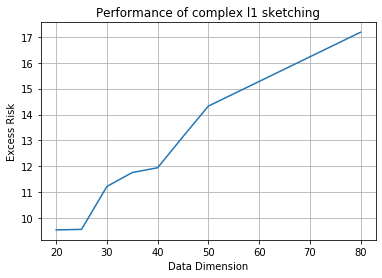

In [103]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

exact_res_list = [noise]*len(ks)
print(total_approx_list)
fig, ax = plt.subplots()
ax.plot(ds, total_approx_list)
#ax.plot(ks, exact_res_list, label='l1 norm of noise')
#ax.legend()

ax.set(xlabel='Data Dimension', ylabel='Excess Risk',
       title='Performance of complex l1 sketching')
ax.grid()

fig.savefig("test.png")
plt.show()





In [ ]:
AA = unfold_mat(A)
yy = unfold_vec(y)



G = gen_gaussian(10, 2, n)
AAA = np.dot(G, AA)
yyy = np.dot(G, yy)

x0 = np.zeros((2*d, 1))

output = minimize(cost_function, x0, args=(AAA, yyy))

y_hat = fit(AA, output.x)

res = norm12(y_hat-unfold_vec(y).reshape(2*n))
print(res)


In [33]:
n = 10
d = 2
A = np.random.rand(n,d)
x = np.random.rand(d,1)
b = np.dot(A, x)
G = np.random.randn(2*d, n)
x_hat = np.linalg.lstsq(np.dot(G, A), np.dot(G, b))[0]
print(np.linalg.norm(np.dot(A, x_hat)-b))


def cost_function(params, X, y):
    return np.linalg.norm(y - fit(X, params))

x0 = np.zeros((d,1))

#output = minimize(cost_function, x0, args=(np.dot(G, A), np.dot(G, b)))
output = minimize(cost_function, x0, args=(A, b))

y_hat = fit(A, output.x.reshape(d,1))
print(np.linalg.norm(y_hat-b))
print(x)
print(output)

1.6004645656917944e-16
0.18979769775272456
[[0.35783786]
 [0.25859946]]
      fun: 1.6550185094689627
 hess_inv: array([[ 0.18397707, -0.16032914],
       [-0.16032914,  0.19562932]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 5
     njev: 9
   status: 0
  success: True
        x: array([0.18955705, 0.34559586])


/Users/zhilif/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


In [100]:
n=100
d=20
A = np.zeros((n,d),dtype=np.complex_)
x = np.zeros((d,1),dtype=np.complex_)
y = np.zeros((n,1),dtype=np.complex_)

for i in range(n):
    for j in range(d):
        a = np.random.rand()
        b = np.random.rand()
        A[i,j]=complex(a,b)

for i in range(d):
    a = np.random.rand()
    b = np.random.rand()
    x[i] = complex(a,b)
    
exact_res = 0
for i in range(n):
    a = np.random.laplace()
    b = np.random.laplace()
    exact_res = exact_res + np.sqrt(a**2+b**2)
    y[i] = np.vdot(A[i,:], x) + complex(a,b)


def fit(X, params):
    return X.dot(params)

def cost_function(params, X, y):
    return norm12(y - fit(X, params))[0]

AA = unfold_mat(A)
yy = unfold_vec(y)

# x0 = np.linalg.lstsq(AA,yy)[0]
x0=np.zeros((2*d, 1))
print(cost_function(unfold_vec(x), AA, yy))
print(exact_res)

output = minimize(cost_function, x0, args=(AA, yy))

y_hat = fit(unfold_mat(A), output.x.reshape(2*d, 1))
print(norm12(y_hat.reshape(2*n, 1)-unfold_vec(y)))


152.9428402499221
152.94284024992214
[693.96938272]


In [21]:
n=10000
k = 2
d=2
a= []
for i in range(n):
    a.append(np.random.rand(d, 1))
res = []

g = np.random.randn(k, d)/k * np.sqrt(np.pi/2)

for item in a:
    res.append(g.dot(item))

diff = 0
for i in range(n):
    #print(np.linalg.norm(res[i], ord=1) - np.linalg.norm(a[i]))
    diff = diff + np.linalg.norm(res[i], ord=1) - np.linalg.norm(a[i])
    
print(diff)



8835.154822457462


In [54]:
n=10000
d=50
A = np.zeros((n,d),dtype=np.complex_)
x = np.zeros((d,1),dtype=np.complex_)
y = np.zeros((n,1),dtype=np.complex_)

for i in range(n):
    for j in range(d):
        a = np.random.rand()*10
        b = np.random.rand()*10
        A[i,j]=complex(a,b)

for i in range(d):
    a = np.random.rand()*10
    b = np.random.rand()*10
    x[i] = complex(a,b)
    
exact_res = 0
for i in range(n):
    a = np.random.rand()*0.01
    b = np.random.rand()*0.01
    exact_res = exact_res + np.sqrt(a**2+b**2)
    y[i] = np.vdot(A[i,:], x) + complex(a,b)


def fit(X, params):
    return np.dot(np.conj(X), params)

def cost_function(params, X, y):
#    return np.linalg.norm(y - fit(X, params.reshape((len(params), 1))), ord=1)
    return norm12(y - fit(X, params.reshape((len(params), 1))))[0]

AA = unfold_mat(A)
yy = unfold_vec(y)
# print(fit(A, x))
# x0 = np.linalg.lstsq(AA,yy)[0]
x0=np.zeros((2*d, 1))
# print(cost_function(x, A, y))
print(exact_res)

k=2
G = gen_gaussian(k, 2, n)
AAA = cvxopt.matrix(np.dot(G, AA))
yyy = cvxopt.matrix(np.dot(G, yy))
x1 = l1(AAA, yyy)
y1 = np.dot(AA, x1)
print("cvxopt residual: " + str(norm12(y1-yy)))


output = minimize(cost_function, x0, args=(AA, yy))

y_hat = fit(AA, output.x.reshape(2*d, 1))
#print(y_hat)
print("scipy residual: " + str(norm12(y_hat-yy)))
#print("scipy residual: " + str(np.linalg.norm(y_hat-y)))



76.62143198516499
cvxopt residual: [38.59193417]
scipy residual: [38.25352655]


In [177]:
n=10
d=2
A = np.random.rand(n,d)
x = np.random.rand(d,1)
y_true = A.dot(x)
e = np.random.randn(n,1)*0.01
y = y_true+e

x_hat = np.linalg.lstsq(A, y)[0]

At = np.random.rand(n,d)
et = np.random.randn(n,1)*0.01
yt=A.dot(x)+et
yhat = A.dot(x_hat)

print(np.linalg.norm(yhat-yt))
print(np.linalg.norm(et))

0.12209037841427205
0.08370741991251424


/Users/zhilif/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':
